In [1]:
%cd /kaggle/working
%rm -rf /kaggle/working/*

/kaggle/working


In [2]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
import gc
from pathlib import Path
import pickle
from tqdm import tqdm
import numpy as np
from multiprocessing import Pool

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torchmetrics import MetricCollection, MeanSquaredError

sys.path.append('/kaggle/src')
from utils.metric import compute_comptetition_metric
from utils.set_seed import seed_base_torch
from utils.feature_contena import Features
from utils.lightning_utils import MyLightningDataModule, MyLightningModule
from utils.postprocess import dynamic_range_nms
from torch_models.dataset import ZzzPatchNoLabelDataset
from torch_models.models import ZzzNoLabelTransformerGRUModel
from consts import ANGLEZ_MEAN, ANGLEZ_STD, ENMO_MEAN, ENMO_STD

MODEL_NAME = "no_label_pred"

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG[MODEL_NAME]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG[MODEL_NAME]['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base_torch(CFG["env"]["seed"])

BLOCK_SIZE = CFG[MODEL_NAME]["execution"]["block_size"]

2023-11-17 00:09:12.903035: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/opt/conda/lib
2023-11-17 00:09:12.903112: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/opt/conda/lib
2023-11-17 00:09:12.903117: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlo

exp_139


In [3]:
DAY_STEPS = 12 * 60 * 24

files = glob(f"{CFG['dataset']['step_csv_dir']}/*.parquet")#[:20]
dfs = []
for file in tqdm(files):
    df = pd.read_parquet(file)

    # same_count
    n_days = int(len(df) // DAY_STEPS) + 1
    df["same_count"] = 0
    for day in range(-n_days, n_days + 1):
        if day == 0:
            continue
        df["_anglez_diff"] = df["anglez"].diff(DAY_STEPS * day)
        df["_anglez_diff"] = df["_anglez_diff"].fillna(1)
        df["same_count"] += (df["_anglez_diff"] == 0).astype(int)
    df["same_count"] = (df["same_count"].clip(0, 5) - 2.5) / 2.5
    df["same_count"] = df["same_count"].astype(np.float16)

    SHIFT_STEPS = 12 * 60 * 6 # 6h
    df["same_count_shift_plus"] = df["same_count"].shift(SHIFT_STEPS).fillna(1.0).astype(np.float16)
    df["same_count_shift_minus"] = df["same_count"].shift(-SHIFT_STEPS).fillna(1.0).astype(np.float16)

    # 特徴量
    df["anglez_diffabs"] = df["anglez"].diff().abs().fillna(0)
    df["large_diff"] = (df["anglez_diffabs"] > 5).astype(int)
    df["large_diff_count"] = df["large_diff"].rolling(10, center=True).mean().fillna(0)
    df["large_diff_count"] = ((df["large_diff_count"] - 0.5) * 2).astype(np.float16)

    # 標準化
    df["anglez"] = (df["anglez"] - ANGLEZ_MEAN) / ANGLEZ_STD
    df["enmo"] = (df["enmo"] - ENMO_MEAN) / ENMO_STD
    df["anglez_diff"] = df["anglez"].diff().fillna(0)
    df["enmo_diff"] = df["enmo"].diff().fillna(0)
    df["anglez"] = df["anglez"].astype(np.float16)
    df["enmo"] = df["enmo"].astype(np.float16)
    df["anglez_diff"] = df["anglez_diff"].astype(np.float16)
    df["enmo_diff"] = df["enmo_diff"].astype(np.float16)
        
    # targetは01にする
    df["onset_target"] = df["onset_target"] / 10
    df["wakeup_target"] = df["wakeup_target"] / 10

    df.drop(columns=["timestamp", "_anglez_diff"], inplace=True)

    dfs.append(df)
gc.collect()

100%|██████████| 277/277 [01:09<00:00,  3.97it/s]


3305

In [4]:
# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
sid2fold = dict(zip(cv_split["series_id"], cv_split["fold"]))

In [5]:
features = Features()
features.add_num_features(["anglez", "enmo"])
features.add_num_features(["anglez_diff", "enmo_diff"])
features.add_num_features(["same_count"])
features.add_num_features(["large_diff_count"])
features.add_num_features(["same_count_shift_plus", "same_count_shift_minus"])

# BLOCK_SIZE ごとに分割
new_dfs = []
for df in tqdm(dfs):
    df = df.sort_values("step").reset_index(drop=True)
    df["fold"] = sid2fold[df["series_id"].values[0]]

    for day, day_df in df.groupby("day"):
        day_df = day_df.sort_values("step").reset_index(drop=True)

        if len(day_df) < BLOCK_SIZE:
            # padding
            pad_size = BLOCK_SIZE - len(day_df)
            if day_df["step"].min() == 0:
                pad_steps = np.arange(-pad_size, 0)
            else:
                pad_steps = np.arange(day_df["step"].max() + 1, day_df["step"].max() + 1 + pad_size)
                
            pad_df = pd.DataFrame({
                "series_id": day_df["series_id"][0],
                "day": day_df["day"][0],
                "step": pad_steps,
                "anglez": 0,
                "enmo": 0,
                "anglez_diff": 0,
                "enmo_diff": 0,
                "onset_target": 0,
                "wakeup_target": 0,
                "fold": day_df["fold"][0],
                "same_count": 0,
                "large_diff_count": 0,
                "same_count_shift_plus": 0,
                "same_count_shift_minus": 0,
            })
            day_df = pd.concat([pad_df, day_df]).sort_values("step").reset_index(drop=True)                

        new_dfs.append(day_df)
        

dfs = new_dfs
gc.collect()

dataset_oof = ZzzPatchNoLabelDataset(dfs, 'train', features, patch_size=CFG[MODEL_NAME]["execution"]["patch_size"])
feats, target = dataset_oof[0]
feats.shape, target.shape

100%|██████████| 277/277 [00:39<00:00,  7.03it/s]


((1440, 96), ())

In [6]:
!rm -r logs

rm: cannot remove 'logs': No such file or directory


In [7]:
%%time

fold_oof_dfs = []
for fold in range(5):
    print(f"== fold {fold} ==")
    
    # 学習・評価データ
    train_dfs = [df for df in dfs if df["fold"].unique()[0] != fold]
    valid_dfs = [df for df in dfs if df["fold"].unique()[0] == fold]
    train_dataset = ZzzPatchNoLabelDataset(train_dfs, mode="train", features=features, patch_size=CFG[MODEL_NAME]["execution"]["patch_size"])
    valid_dataset = ZzzPatchNoLabelDataset(valid_dfs, mode="train", features=features, patch_size=CFG[MODEL_NAME]["execution"]["patch_size"])
    data_module = MyLightningDataModule(train_dataset, valid_dataset, batch_size=32)

    # モデル
    num_training_steps = len(train_dataset) // 32 * 10
    
    model = ZzzNoLabelTransformerGRUModel(
        max_len=BLOCK_SIZE // CFG[MODEL_NAME]["execution"]["patch_size"],
        input_numerical_size=len(features.all_features()) * CFG[MODEL_NAME]["execution"]["patch_size"],
        **CFG[MODEL_NAME]["params"],
        out_size=1,
    )
    pl_model = MyLightningModule(
        model=model,
        lr=0.0005, 
        loss_fn=nn.BCEWithLogitsLoss(),
        num_training_steps=num_training_steps,
    )
    
    # コールバック
    cp_callback = ModelCheckpoint(
        "logs/", 
        filename=f"best_model_fold{fold}",
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        save_last=False,
    )
    es_callback = EarlyStopping(
        monitor="val_loss",
        mode="min",
        patience=4,
    )

    # 学習
    trainer = pl.Trainer(
        callbacks=[cp_callback, es_callback],
        deterministic=True,
        )
    trainer.fit(pl_model, datamodule=data_module)

    # 推論
    pl_model = MyLightningModule.load_from_checkpoint(
        f"logs/best_model_fold{fold}.ckpt", 
        model=model,
    ).to("cuda")
    pl_model.eval()
    preds = []
    with torch.no_grad():
        for X, y in data_module.val_dataloader():
            pred = torch.sigmoid(pl_model(X.to("cuda"))).detach().cpu().numpy()
            preds.append(pred)

    oof_dfs = []
    for pred, df in zip(np.concatenate(preds), valid_dfs):
        df = df.iloc[CFG[MODEL_NAME]["execution"]["patch_size"] // 2: len(df): CFG[MODEL_NAME]["execution"]["patch_size"]].reset_index(drop=True)
        df["has_label_oof"] = pred
        oof_dfs.append(df)

    oof_df = pd.concat(oof_dfs).dropna(subset=["has_label"])
    oof_df = oof_df[["series_id", "step", "has_label_oof", "day", "has_label"]].drop_duplicates(["series_id", "day"])
    fold_oof_dfs.append(oof_df)

    del model, preds, oof_df, oof_dfs
    gc.collect()
train = pd.concat(fold_oof_dfs)
train.to_parquet(f"{CFG['output_dir']}/oof.parquet", index=False)
del fold_oof_dfs
gc.collect()

== fold 0 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.7286, 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.1683, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.1778, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.1685, 


Validation: 0it [00:00, ?it/s]

[epoch 3] valid: BCEWithLogitsLoss=0.1523, 


Validation: 0it [00:00, ?it/s]

[epoch 4] valid: BCEWithLogitsLoss=0.1633, 


Validation: 0it [00:00, ?it/s]

[epoch 5] valid: BCEWithLogitsLoss=0.1645, 


Validation: 0it [00:00, ?it/s]

[epoch 6] valid: BCEWithLogitsLoss=0.1512, 


Validation: 0it [00:00, ?it/s]

[epoch 7] valid: BCEWithLogitsLoss=0.1658, 


Validation: 0it [00:00, ?it/s]

[epoch 8] valid: BCEWithLogitsLoss=0.1592, 


Validation: 0it [00:00, ?it/s]

[epoch 9] valid: BCEWithLogitsLoss=0.1626, 


Validation: 0it [00:00, ?it/s]

[epoch 10] valid: BCEWithLogitsLoss=0.1597, 
== fold 1 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.7483, 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.1591, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.1119, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.1115, 


Validation: 0it [00:00, ?it/s]

[epoch 3] valid: BCEWithLogitsLoss=0.1136, 


Validation: 0it [00:00, ?it/s]

[epoch 4] valid: BCEWithLogitsLoss=0.1169, 


Validation: 0it [00:00, ?it/s]

[epoch 5] valid: BCEWithLogitsLoss=0.1062, 


Validation: 0it [00:00, ?it/s]

[epoch 6] valid: BCEWithLogitsLoss=0.1147, 


Validation: 0it [00:00, ?it/s]

[epoch 7] valid: BCEWithLogitsLoss=0.1184, 


Validation: 0it [00:00, ?it/s]

[epoch 8] valid: BCEWithLogitsLoss=0.1461, 


Validation: 0it [00:00, ?it/s]

[epoch 9] valid: BCEWithLogitsLoss=0.1112, 
== fold 2 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.6512, 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.1263, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.1313, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.1254, 


Validation: 0it [00:00, ?it/s]

[epoch 3] valid: BCEWithLogitsLoss=0.1174, 


Validation: 0it [00:00, ?it/s]

[epoch 4] valid: BCEWithLogitsLoss=0.1157, 


Validation: 0it [00:00, ?it/s]

[epoch 5] valid: BCEWithLogitsLoss=0.1066, 


Validation: 0it [00:00, ?it/s]

[epoch 6] valid: BCEWithLogitsLoss=0.1160, 


Validation: 0it [00:00, ?it/s]

[epoch 7] valid: BCEWithLogitsLoss=0.1077, 


Validation: 0it [00:00, ?it/s]

[epoch 8] valid: BCEWithLogitsLoss=0.1088, 


Validation: 0it [00:00, ?it/s]

[epoch 9] valid: BCEWithLogitsLoss=0.1091, 
== fold 3 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.5896, 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.1356, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.1680, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.1468, 


Validation: 0it [00:00, ?it/s]

[epoch 3] valid: BCEWithLogitsLoss=0.1356, 


Validation: 0it [00:00, ?it/s]

[epoch 4] valid: BCEWithLogitsLoss=0.1329, 


Validation: 0it [00:00, ?it/s]

[epoch 5] valid: BCEWithLogitsLoss=0.1456, 


Validation: 0it [00:00, ?it/s]

[epoch 6] valid: BCEWithLogitsLoss=0.1458, 


Validation: 0it [00:00, ?it/s]

[epoch 7] valid: BCEWithLogitsLoss=0.1513, 


Validation: 0it [00:00, ?it/s]

[epoch 8] valid: BCEWithLogitsLoss=0.1321, 


Validation: 0it [00:00, ?it/s]

[epoch 9] valid: BCEWithLogitsLoss=0.1392, 


Validation: 0it [00:00, ?it/s]

[epoch 10] valid: BCEWithLogitsLoss=0.1808, 


Validation: 0it [00:00, ?it/s]

[epoch 11] valid: BCEWithLogitsLoss=0.1551, 


Validation: 0it [00:00, ?it/s]

[epoch 12] valid: BCEWithLogitsLoss=0.1568, 
== fold 4 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.6086, 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.1646, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.1676, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.2052, 


Validation: 0it [00:00, ?it/s]

[epoch 3] valid: BCEWithLogitsLoss=0.1500, 


Validation: 0it [00:00, ?it/s]

[epoch 4] valid: BCEWithLogitsLoss=0.1518, 


Validation: 0it [00:00, ?it/s]

[epoch 5] valid: BCEWithLogitsLoss=0.1467, 


Validation: 0it [00:00, ?it/s]

[epoch 6] valid: BCEWithLogitsLoss=0.1705, 


Validation: 0it [00:00, ?it/s]

[epoch 7] valid: BCEWithLogitsLoss=0.1429, 


Validation: 0it [00:00, ?it/s]

[epoch 8] valid: BCEWithLogitsLoss=0.1456, 


Validation: 0it [00:00, ?it/s]

[epoch 9] valid: BCEWithLogitsLoss=0.1559, 


Validation: 0it [00:00, ?it/s]

[epoch 10] valid: BCEWithLogitsLoss=0.1600, 


Validation: 0it [00:00, ?it/s]

[epoch 11] valid: BCEWithLogitsLoss=0.1581, 
CPU times: user 1h 12min 40s, sys: 45.5 s, total: 1h 13min 25s
Wall time: 35min 47s


0

accuracy: 0.963513161323951
[[2627  253]
 [  27 4767]]


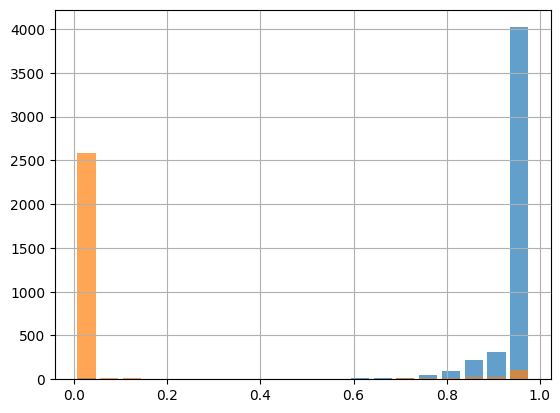

In [8]:
from sklearn.metrics import confusion_matrix

train[train["has_label"]==True]["has_label_oof"].hist(bins=20, alpha=0.7, rwidth=0.8)
train[train["has_label"]==False]["has_label_oof"].hist(bins=20, alpha=0.7, rwidth=0.8)
thresh = 0.25
train["has_label_pred"] = train["has_label_oof"] > thresh
accuracy = (train["has_label_pred"] == train["has_label"]).mean()
print(f"accuracy: {accuracy}")
print(confusion_matrix(train["has_label"].astype(bool), train["has_label_pred"].astype(bool)))

In [9]:
%cp -r logs {CFG["output_dir"]}

In [10]:
train

,series_id,step,has_label_oof,day,has_label,has_label_pred
120,d25e479ecbb7,6,0.979888,0,True,True
0,d25e479ecbb7,15846,0.980084,1,True,True
0,d25e479ecbb7,33126,0.979971,2,True,True
0,d25e479ecbb7,50406,0.980098,3,True,True
0,d25e479ecbb7,67686,0.979546,4,True,True
...,...,...,...,...,...,...
0,c38707ef76df,504366,0.002140,30,False,False
0,c38707ef76df,521646,0.971994,31,True,True
0,c38707ef76df,538926,0.971981,32,True,True
0,c38707ef76df,556206,0.972012,33,True,True
